# Clustering the neighborhoods in Toronto

In [58]:
import urllib
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import folium
import requests
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

### Part . 1

1. Due to policy in **China**, wikipedia is not available. I downloaded the web page in other ways.\
2. Using BeautifulSoup, I get the details of that wikipedia page

In [2]:
wiki = 'List of postal codes of Canada_ M - Wikipedia.htm'

htmlfile = open(wiki, 'r', encoding='utf-8')
htmlhandle = htmlfile.read()
soup = BeautifulSoup(htmlhandle, 'lxml')

3. Collecting all the tables

In [3]:
table = soup.find('table')

4. Analysing and storing all the data we want.

In [4]:
postcode = []
borough = []
neighborhood = []
for row in table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells) == 3:
        postcode.append(cells[0].find(text=True))
        borough.append(cells[1].find(text=True))
        neighborhood.append(cells[2].find(text=True).replace("\n", ""))


5. Storing all the data into a pandas **DataFrame** and dropping all the _'Not assigned'_ **borough** rows

In [5]:
columns = ['PostalCode','Borough','Neighborhood']
Toronto = pd.DataFrame(columns = columns)
Toronto['PostalCode'] = postcode
Toronto['Borough'] = borough
Toronto['Neighborhood'] = neighborhood
Toronto = Toronto[Toronto['Borough'] != 'Not assigned']
Toronto = Toronto.reset_index(drop = True)
Toronto.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


6. Check if there is any _'Not assigned'_ **neighborhood** data

In [6]:
a = Toronto['Neighborhood']=='Not assigned'
a.sum()

0

7. Using apply function, I add **', '** at the end of each Neighborhood name.\
    Using groupby function, I merged the DataFrame.\
    Using apply function, I cut the unnecessary ', ' at the end

In [7]:
Toronto['Neighborhood'] = Toronto['Neighborhood'].apply(lambda x: x+', ')
Toronto_df = Toronto.groupby(by = ['PostalCode','Borough']).sum()
Toronto_df['Neighborhood']=Toronto_df['Neighborhood'].apply(lambda x: x[:-3])
Toronto_df = Toronto_df.reset_index()
Toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malver"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Unio"
2,M1E,Scarborough,"Guildwood, Morningside, West Hil"
3,M1G,Scarborough,Wobur
4,M1H,Scarborough,Cedarbra


In [8]:
Toronto_df.shape

(103, 3)

### Part . 2

8. Getting latitude and longitude.\
    I kept getting None by using geocode. Therefore, I choose the csv file here.

In [9]:
latlng = pd.read_csv(r'Geospatial_Coordinates.csv')
latlng.columns = ['PostalCode', 'Latitude', 'Longitude']
latlng.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


9. Merge this two DataFrame into one.

In [10]:
Toronto_latlng = pd.merge(Toronto_df, latlng, on='PostalCode', how='left')
Toronto_latlng.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malver",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Unio",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hil",43.763573,-79.188711
3,M1G,Scarborough,Wobur,43.770992,-79.216917
4,M1H,Scarborough,Cedarbra,43.773136,-79.239476


### Part . 3

10. Create a map of Toronto with neighborhoods superimposed on top.

In [11]:
latitude = 43.6532
longitude = -79.3832
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, borough, neighborhood in zip(Toronto_latlng['Latitude'], Toronto_latlng['Longitude'], Toronto_latlng['Borough'], Toronto_latlng['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [ ]:
CLIENT_ID = 'HMK2MMTYUEHGBKREGXILXYF245VXGG4CI4OOE05Q0QW1PAT4' # your Foursquare ID
CLIENT_SECRET = '***' # your Foursquare Secret
VERSION = '20180323' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

#### Get the access to foursquare

In [28]:
Toronto_latlng.loc[55, 'Neighborhood']
neighborhood_latitude = Toronto_latlng.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = Toronto_latlng.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = Toronto_latlng.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Rouge, Malver are 43.806686299999996, -79.19435340000001.


#### Define a function to get all nearby venues

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
Toronto_venues = getNearbyVenues(names=Toronto_latlng['Neighborhood'],
                                   latitudes=Toronto_latlng['Latitude'],
                                   longitudes=Toronto_latlng['Longitude']
                                  )

Rouge, Malver
Highland Creek, Rouge Hill, Port Unio
Guildwood, Morningside, West Hil
Wobur
Cedarbra
Scarborough Villag
East Birchmount Park, Ionview, Kennedy Par
Clairlea, Golden Mile, Oakridg
Cliffcrest, Cliffside, Scarborough Village Wes
Birch Cliff, Cliffside Wes
Dorset Park, Scarborough Town Centre, Wexford Height
Maryvale, Wexfor
Agincour
Clarks Corners, Sullivan, Tam O'Shante
Agincourt North, L'Amoreaux East, Milliken, Steeles Eas
L'Amoreaux Wes
Upper Roug
Hillcrest Villag
Fairview, Henry Farm, Oriol
Bayview Villag
Silver Hills, York Mill
Newtonbrook, Willowdal
Willowdale Sout
York Mills Wes
Willowdale Wes
Parkwood
Don Mills Nort
Flemingdon Park, Don Mills Sout
Bathurst Manor, Downsview North, Wilson Height
Northwood Park, York Universit
CFB Toronto, Downsview Eas
Downsview Wes
Downsview Centra
Downsview Northwes
Victoria Villag
Woodbine Gardens, Parkview Hil
Woodbine Height
The Beache
Leasid
Thorncliffe Par
East Toront
The Danforth West, Riverdal
The Beaches West, India Bazaa
St

In [33]:
Toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmon",100,100,100,100,100,100
Agincour,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles Eas",2,2,2,2,2,2
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletow",12,12,12,12,12,12
"Alderwood, Long Branc",10,10,10,10,10,10
...,...,...,...,...,...,...
Willowdale Wes,5,5,5,5,5,5
Wobur,5,5,5,5,5,5
"Woodbine Gardens, Parkview Hil",11,11,11,11,11,11


#### Enable onehot codding

In [35]:
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmon",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.02,0.0,0.000000,0.0,0.0,0.01,0.0,0.0,0.01
1,Agincour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.083333,0.0,0.0,0.00,0.0,0.0,0.00
4,"Alderwood, Long Branc",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Willowdale Wes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00
95,Wobur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00
96,"Woodbine Gardens, Parkview Hil",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00
97,Woodbine Height,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.090909,0.0,0.0,0.00,0.0,0.0,0.00


In [39]:
num_top_venues = 5

for hood in Toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Toronto_grouped[Toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmon----
             venue  freq
0      Coffee Shop  0.07
1       Restaurant  0.05
2  Thai Restaurant  0.04
3             Café  0.04
4              Bar  0.03


----Agincour----
                       venue  freq
0  Latin American Restaurant  0.25
1               Skating Rink  0.25
2             Breakfast Spot  0.25
3                     Lounge  0.25
4             Massage Studio  0.00


----Agincourt North, L'Amoreaux East, Milliken, Steeles Eas----
                       venue  freq
0                       Park   0.5
1                 Playground   0.5
2             Massage Studio   0.0
3  Middle Eastern Restaurant   0.0
4         Mexican Restaurant   0.0


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletow----
                  venue  freq
0         Grocery Store  0.17
1           Pizza Place  0.17
2  Fast Food Restaurant  0.08
3              Pharmacy  0.08
4        Discount Store  0.08


----Alderwoo

#### Utilizing the Kmeans method

In [43]:
kclusters = 5
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 0, 0, 2, 2, 2, 2, 2], dtype=int32)

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [55]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmon",Coffee Shop,Restaurant,Café,Thai Restaurant,Sushi Restaurant,Bar,Gastropub,Lounge,Seafood Restaurant,Gym
1,Agincour,Skating Rink,Latin American Restaurant,Breakfast Spot,Lounge,Women's Store,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Women's Store,Discount Store,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pizza Place,Pharmacy,Fast Food Restaurant,Japanese Restaurant,Video Store,Beer Store,Sandwich Place,Fried Chicken Joint,Discount Store
4,"Alderwood, Long Branc",Pizza Place,Skating Rink,Athletics & Sports,Pharmacy,Pool,Pub,Sandwich Place,Coffee Shop,Gym,Garden Center


In [56]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = Toronto_latlng

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malver",43.806686,-79.194353,0.0,Fast Food Restaurant,Women's Store,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Unio",43.784535,-79.160497,2.0,Home Service,Bar,Women's Store,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Deli / Bodega
2,M1E,Scarborough,"Guildwood, Morningside, West Hil",43.763573,-79.188711,2.0,Electronics Store,Intersection,Mexican Restaurant,Rental Car Location,Breakfast Spot,Medical Center,Spa,Doner Restaurant,Donut Shop,Drugstore
3,M1G,Scarborough,Wobur,43.770992,-79.216917,2.0,Coffee Shop,Convenience Store,Indian Restaurant,Korean Restaurant,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Department Store
4,M1H,Scarborough,Cedarbra,43.773136,-79.239476,2.0,Bakery,Bank,Fried Chicken Joint,Athletics & Sports,Hakka Restaurant,Thai Restaurant,Gas Station,Caribbean Restaurant,Diner,Department Store


In [84]:
Toronto_merged[['Cluster Labels']] = Toronto_merged[['Cluster Labels']].fillna(0)
Toronto_merged[['Cluster Labels']] = Toronto_merged[['Cluster Labels']].astype(dtype = int)
Toronto_merged[['Cluster Labels']]

,Cluster Labels
0,0
1,2
2,2
3,2
4,2
...,...
98,1
99,0
100,0
101,0


#### Make the map

In [85]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### It seems that github cannot load the map object. Therefore I put a screenshot here.

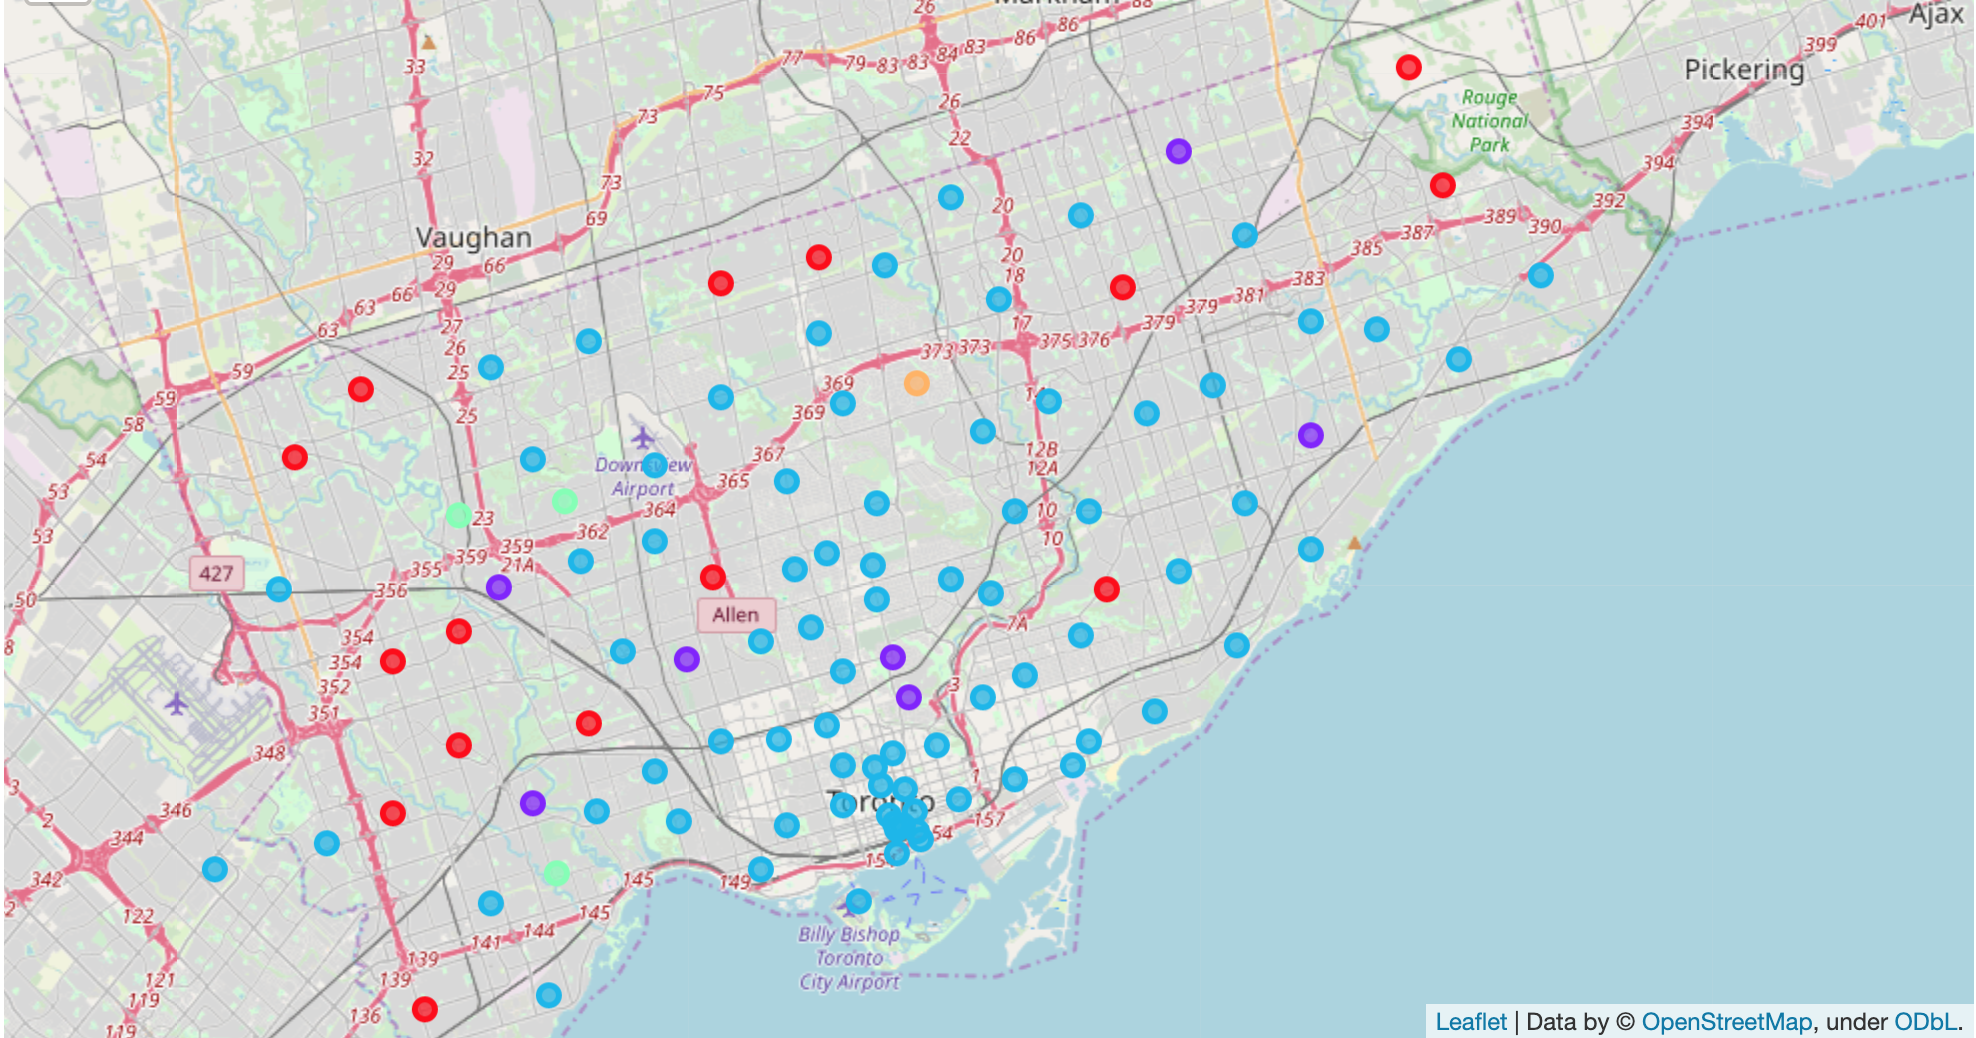

In [89]:
from PIL import Image
I = Image.open('scrren.png') 
I